In [1]:
import pandas as pd
import numpy as np
import geopandas
import ast
import datetime
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.formula.api as smf
# import plotly.figure_factory as ff
import tqdm as tq
from itertools import chain, combinations
from pandas.tseries.holiday import *
from pandas.tseries.offsets import CustomBusinessDay
#! pip install geopandas

In [2]:
def strict_next_monday(dt: datetime) -> datetime:
    """
    Si el festivo cae en un día diferente a lunes, se corre al próximo lunes
    """
    if dt.weekday() > 0:
        return dt + timedelta(7-dt.weekday())
    return dt
class ColombianBusinessCalendar(AbstractHolidayCalendar):
    rules = [
        # festivos fijos
        Holiday('Año nuevo', month=1, day=1),
        Holiday('Día del trabajo', month=5, day=1),
        Holiday('Día de la independencia', month=7, day=20),
        Holiday('Batalla de Boyacá', month=8, day=7),
        Holiday('Inmaculada Concepción', month=12, day=8),
        Holiday('Navidad', month=12, day=25),
        # festivos relativos a la pascua
        Holiday('Jueves santo', month=1, day=1, offset=[Easter(), Day(-3)]),
        Holiday('Viernes santo', month=1, day=1, offset=[Easter(), Day(-2)]),
        Holiday('Ascención de Jesús', month=1, day=1, offset=[Easter(), Day(43)]),
        Holiday('Corpus Christi', month=1, day=1, offset=[Easter(), Day(64)]),
        Holiday('Sagrado Corazón de Jesús', month=1, day=1, offset=[Easter(), Day(71)]),
        # festivos desplazables (Emiliani)
        Holiday('Epifanía del señor', month=1, day=6, observance=strict_next_monday),
        Holiday('Día de San José', month=3, day=19, observance=strict_next_monday),
        Holiday('San Pedro y San Pablo', month=6, day=29, observance=strict_next_monday),
        Holiday('Asunción de la Virgen', month=8, day=15, observance=strict_next_monday),
        Holiday('Día de la raza', month=10, day=12, observance=strict_next_monday),
        Holiday('Todos los santos', month=11, day=1, observance=strict_next_monday),
        Holiday('Independencia de Cartagena', month=11, day=11, observance=strict_next_monday)
    ]
    
Colombian_BD = CustomBusinessDay(calendar=ColombianBusinessCalendar())
calendar = ColombianBusinessCalendar()
# festivos para la franja horaria
festivos = pd.to_datetime(calendar.holidays(start='2014-01-01', end='2022-12-31'))

In [3]:
def quincena(df_:pd.DataFrame,fecha_:str):
    fin_mes=(df_[fecha_]+pd.Timedelta(1,"d")).dt.day
    quince_fin_atras=(df_[fecha_]+pd.Timedelta(2,"d")).dt.day
    dia_=df_[fecha_].dt.day
    filtro_quincena=((fin_mes==1)|
                    (quince_fin_atras==1) |
                    (dia_.isin([14,15,1])))
    df_["QUINCENA"]=np.where(filtro_quincena,1,0)
    
    return df_

def historia_atras(df_:pd.DataFrame, response:str, groupby:str,periodos:int)->pd.DataFrame:
    """
    
    """
    list_periodos=pd.Series(range(1,periodos+1))
    max_periodo=list_periodos.max()
    new_columns=list(response+pd.Series(range(1,periodos+1)).astype(str))
    list_columns=[*new_columns,*list(df_.columns)]
    
    df_new=pd.DataFrame(columns=list_columns)
    new_dict={}
    for i  in  new_columns:
        new_dict.update({i:int })
    df_new=df_new.astype(new_dict)
    df_new=df_new.astype(df_.dtypes)
    clases=list(df_[groupby].unique())
    for clase in clases:
        filtro_=df_[groupby]==clase
        df_temp=df_[filtro_].copy()
        n_temp=df_temp.shape[0]
        for periodo in list(list_periodos):
            df_temp[new_columns[periodo-1]]=0
            temp_=[*([0]*periodo), *list(df_temp[response].iloc[:-periodo].copy())]
            df_temp[new_columns[periodo-1]]=temp_#.copy()
            df_temp=df_temp.reset_index().drop(labels="index",axis=1)
        df_new=pd.concat([df_new.iloc[periodo:],df_temp.copy()],axis=0).copy()
    df_new=df_new.reset_index().drop(labels="index",axis=1)
    return df_new

def powerset(k):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list([*["Y"+str(i) for i in range(1,k)],*["CLASE_ACCIDENTE","DIA_SEMANA","Y14"]])
    comb_=list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    
    formulas=["Y~"+"+".join(list(comb_[i])) for i in range(1,len(comb_))]
    return formulas

def modelo_lm(df_:pd.DataFrame,formula_:str):
    """
    Ajusta un modelo de regresión lineal según la formula
    
    """
    modelo= smf.ols(formula=formula_, data=df_)
    modelo=modelo.fit()
    
    return modelo

def rmse(y_obs:pd.Series,y_pred:pd.Series)->float:
    """
    
    """
    residuales=(y_obs-y_pred)**2
    rmse=np.sqrt(residuales.mean())
    
    return rmse

def mae(y_obs:pd.Series,y_pred:pd.Series)->float:
    """
    """
    residuales=abs(y_obs-y_pred)
    mae=residuales.mean()
    
    return mae

def comparacion_mae(mae_train:float,mae_test:float):
    """
    """
    variacion_porcentual=100*abs(mae_train-mae_test)/mae_train
    
    return variacion_porcentual

def validacion_modelo(df_train:pd.DataFrame, df_test:pd.DataFrame,formula_:str ):
    """
    """
    response=formula_.split("~")[0]
    modelo_=modelo_lm(df_train,formula_)
    y_pred_train=modelo_.predict()
    y_pred_test=modelo_.predict(df_test)
    y_obs_train=df_train[response].copy()
    y_obs_test=df_test[response].copy()
    mae_train=mae(y_obs_train, y_pred_train)
    mae_test=mae(y_obs_test,y_pred_test)
    rmse_train=rmse(y_obs_train, y_pred_train)
    rmse_test=rmse(y_obs_test,y_pred_test)
    variacion_validacion=comparacion_mae(mae_train,mae_test)
    df_completo=pd.concat([df_train,df_test], axis=0)
    y_pred=modelo_.predict(df_completo)
    result_data=pd.DataFrame({"Formula modelo":[formula_],
                              "Modelo":[modelo_],
                              "y_pred":[y_pred],
                              "RMSE train":[rmse_train],
                             "RMSE test":[rmse_test],
                             "MAE train":[mae_train],
                             "MAE test":[mae_test],
                             "Variación validación (MAE)":[variacion_validacion]})
    return result_data

def validacion_mult_modelos(df_train:pd.DataFrame, df_test:pd.DataFrame,formulas:list ):
    """
    """
    
    columns_result=["Formula modelo","RMSE train","RMSE test","MAE train","MAE test","Variación validación (MAE)"]
    result_modelos=pd.DataFrame(columns=columns_result)
    dict_types={"Formula modelo":str,
                "RMSE train":float,
                "RMSE test":float,
                "MAE train":float,
                "MAE test":float,
                "Variación validación (MAE)":float}
    result_modelos=result_modelos.astype(dict_types)

    for formula in tq.tqdm(formulas):
        fila=validacion_modelo(df_train, df_test,formula)
        result_modelos=pd.concat([result_modelos,fila],axis=0)
    
    return result_modelos


# Introducción 

Medellín es una de las ciudades densamente pobladas en el mundo, en el 2015 la ONU clasifico a Medellín en la tercera ciudad con mas habiltantes por $km^2$ en el mundo. Por otra parte en el 2017 Medellín ocupo el primer lugar en accidentalidad con respecto al país lo cual es un dato preocupante ¿como ha sido la tendencia? ¿que soluciones pueden existir? En MEData se cuenta con una base de datos con 270,759 accidentes entre los año 2014 y 2020.

# Objetivos

- Pronosticar el número de accidentes entre los año 2021 y 2022 por clase de accidente ya que aun no se cuenta con información actualizada.

- Clasificar los barrios de medellín para identificar las zonas con mayor accidentalidad y dar sugerencias.

# Exploración de los datos

Con la lectura de datos se analiza el tipo de accidentes.


In [4]:
datos=pd.read_csv("incidentes_viales.csv",sep=";",encoding='ansi',engine="python")
datos["CLASE_ACCIDENTE"].value_counts(dropna=False)

Choque               180575
Otro                  30039
Atropello             25585
Caida Ocupante        17630
Volcamiento           10368
Caída de Ocupante      6509
Incendio                 35
Caída Ocupante           17
NaN                       6
Caida de Ocupante         1
Name: CLASE_ACCIDENTE, dtype: int64

En la Table 1 se observa los tipos de accidente que hay, en este caso existen 6 registros NA y la Caída ocupante esta escrita de multiples formas, se elimina el NA y se unifica Caida ocupante.

Otra cosa que se observa es que el accidente mas frecuente es de choque, pero Incendio es poco frecuente ya que son 6 accidentes por año para el modelo predictivo esto esta mas allá del alcance de un modelo matematico para alcanzar una predicción, por lo tanto se excluye este tipo de accidente para el modelo predictivo.



In [5]:
filtro=datos["CLASE_ACCIDENTE"].isna() # omit na 
datos=datos[~filtro] # filtro
diccionario_temp={'Caida Ocupante':"Caida ocupante",
                  'Caída de Ocupante':"Caida ocupante",
                  'Caída Ocupante':"Caida ocupante", 
                  'Caida de Ocupante':"Caida ocupante"} 
datos["CLASE_ACCIDENTE"]=datos["CLASE_ACCIDENTE"].replace(diccionario_temp)
datos.isna().sum()

AÑO                          0
CBML                     18156
CLASE_ACCIDENTE              0
DIRECCION                    0
DIRECCION ENCASILLADA      391
DISEÑO                    1148
EXPEDIENTE                 110
FECHA_ACCIDENTE              0
FECHA_ACCIDENTES             0
GRAVEDAD_ACCIDENTE           0
MES                          0
NRO_RADICADO                 5
NUMCOMUNA                    0
BARRIO                   19006
COMUNA                   12798
LOCATION                     0
X                            0
Y                            0
dtype: int64

En la Table se observa las columnas de data frame con la cantidad de NA que contiene, como uno de los propositos es la agrupación por barrios se debe analizar mas a fondo la columna BARRIO ya que cuenta con mas de 19006 registros NA, sin embargo la localización geografica no contiene NA por lo que puede servir para recuperar información de ese barrio ya que a la hora de digitar pueden suceder varios eventos como en el registro no se tiene claro el barrio en su momento.

## Preparación datos modelo


### Preparación de  datos modelo de agrupamiento

Para agrupar los barrios de Medellín  se usara un shape que contiene el mapa de Medellín discriminado por los barrios. Y además otro shape que contiene las vías en zona urbana y rural de medellín.

Los datos cuentan con el registro de latitud y longitud por cada accidente, también cuenta con el nombre de cada barrio.


In [6]:
shapefile = geopandas.read_file("Barrio_Vereda.shp") 
shapefile=shapefile[["NOMBRE", "SHAPEAREA", "SHAPELEN", "geometry"]]
tabla_temp=pd.DataFrame({"Mapa":shapefile.NOMBRE.nunique(), "Datos":datos.BARRIO.nunique()}, index=["Cantidad de barrios"])
tabla_temp

Mapa  Datos
Cantidad de barrios   320    490

En la Table 2 se observa que los datos de MEData se tienen 490 barrios, mientras que en el shape cuenta con información de 320 barrios para este caso como se desea realizar un analisis geo espacial se trabaja con el shape.

Pasos a seguir: 

* Las coordenadas que se encuentran en MEData tienen un sistema de referencia crs: ITRF94, se transforman los datos en formato geopandas (en python especificando el sistema de referencia).

* Luego se trabajara con un sistema de referencia crs: EPSG:4326, por ende para todo analisis espacial en este trabajo es con este sistema de referencia.

* Se realiza una intersección del mapa de Medellín con los datos.

In [7]:
# str to list
list_columns=["FECHA_ACCIDENTE","CLASE_ACCIDENTE","BARRIO","LOCATION" ]
datos=datos[list_columns]
datos["LOCATION"]=datos["LOCATION"].apply(lambda x: ast.literal_eval(x))
# dataframe to geopandas
# sistema de referencia datos : ITRF94
gdf = geopandas.GeoDataFrame( 
    datos, geometry=geopandas.points_from_xy(datos.LOCATION.apply(lambda x: x[0]),
                                             datos.LOCATION.apply(lambda x: x[1]),
                                            crs="ITRF94"))
# cambiar sistema de refencia 
# sistema de refencia de barrios es: EPSG:4326
gdf=gdf.to_crs("EPSG:4326")
# join barrios medellin y datos
datos_join=geopandas.sjoin(gdf,shapefile , how='left') 

filtro_mapa=(datos_join.SHAPEAREA.isna())
datos_join.loc[filtro_mapa, "NOMBRE"]=datos_join.loc[filtro_mapa, "BARRIO"]
datos_join.loc[filtro_mapa,"BARRIO"].value_counts(dropna=False)

tabla_temp=pd.DataFrame(datos_join.loc[datos_join.SHAPEAREA.isna(),"BARRIO"].value_counts(dropna=False))#.sum()
tabla_temp=pd.concat([tabla_temp,pd.DataFrame({"BARRIO":int(tabla_temp.sum())},index=["Total"])],axis=0)
tabla_temp

BARRIO
NaN                             18840
0                                1036
Guayabal                          354
1510                               16
Caribe                              9
Los Balsos No.2                     3
Cabecera San Antonio de Prado       3
El Chagualo                         3
Asomadera No. 1                     2
Plaza de Ferias                     2
El Progreso                         1
Palermo                             1
Terminal de Transporte              1
Fuente Clara                        1
Parque Norte                        1
Sin Inf                             1
Volcana Guayabal                    1
Área de Expansión Pajarito          1
Santa Mónica                        1
La Alpujarra                        1
Total                           20278

En la Table se tiene la frecuencia por barrios que no se encuentran en el mapa. Luego de hacer la intersección entre los barrios, aquellos que no se encuentran en el mapa tiene los siguientes nombres estos datos no se incluiran en los modelos por que según la geo localización no pertenecen a Medellín donde pueden pertenecer a municipios aledaños o de alguna manera no se digito bien la información.



In [8]:
datos_join=geopandas.sjoin(shapefile,gdf , how='inner') 
datos_join.shape
# vias_medellin=geopandas.read_file("planeacion_gdb/planeacion_gdb.shp")
# vias_medellin=vias_medellin.to_crs("EPSG:4326")

(250481, 9)

De los 270,759 accidentes que se encuentran registrados solo se considera que ocurrieron en la ciudad de Medellín 250,481.

### Preparación de  datos modelo predictivo

In [9]:
datos_join["FECHA_ACCIDENTE_"]=pd.to_datetime(datos_join["FECHA_ACCIDENTE"].apply(lambda x:x.split(" ")[0]+" 00:00:00")) # x.replace("Sin Inf","00:00:00") ))
pd.DataFrame({"Fecha minima":[datos_join["FECHA_ACCIDENTE_"].min()],
             "Fecha maxima":[datos_join["FECHA_ACCIDENTE_"].max()],
             "Días": [(datos_join["FECHA_ACCIDENTE_"].max()-datos_join["FECHA_ACCIDENTE_"].min()).days]})

Fecha minima Fecha maxima  Días
0   2014-01-08   2020-12-08  2526

En la Table 2 se observa que el periodo de tiempo que comprende los datos esta entre el 8 de Enero del 2014 al 8 de Diciembre del 2020, un total de 2526 días de información.



Para realizar un modelo predictivo de los accidentes a futuro se debe tener en cuenta que en el data frame cada fila representa un solo accidente y como el objetivo es predecir por tiempo la cantidad de accidentes, definimos:

* $Y_{(t,a)}:$ El número de accidentes en el día $t$ en la ciudad de Medellín en el tipo de accidente $a$. Para obtener esta variable se realiza lo siguiente.

* $t$: El día en el calendario, día, mes, año.

* $a$: El tipo de accidente (excluyendo incendio)

Para construir un data frame con la base de datos se seguiran los siguientes pasos:

<b><center> pasos a seguir </center></b>

* Cada fila representa un accidente, se crea una columna $Y=1$.

* Se crea un dataframe (datos_modelo) con la columna que contenga los tipos de accidentes (excluyendo los incendios) y por cada tipo se generan fechas por día según la Table 2.

* Con este data frame se realiza un join, datos_modelo left join datos (con intersección mapa).

* Con la union de estos datos los na en la variable respuesta se remplazan por 0, es decir, estos días no hubo registro de algún tipo de accidente.

* Estos resultados se agrupan por tipo de accidente y fecha del accidente y sumando la columna Y.


In [68]:
datos_temp=pd.DataFrame(pd.date_range(start=datos_join["FECHA_ACCIDENTE_"].min(),
                                      end=datos_join["FECHA_ACCIDENTE_"].max()))
len_accidentes=datos_join["CLASE_ACCIDENTE"].nunique()
datos_join["Y"]=1 # cantidad de accidentes
seq_dias=datos_temp.shape[0] # secuencia de dias
tipo_accidente=np.repeat( datos_join["CLASE_ACCIDENTE"].unique(),(seq_dias))  # tipo por la secuencia del tiempo
datos_modelo=pd.DataFrame({"FECHA_ACCIDENTE":list(datos_temp[0])*len_accidentes,
                          "CLASE_ACCIDENTE":tipo_accidente,
                          "DIA_SEMANA":list(datos_temp[0].dt.weekday)*len_accidentes } )
datos_modelo=datos_modelo.merge(datos_join[["CLASE_ACCIDENTE","Y","FECHA_ACCIDENTE_"]],how="left", 
                   left_on=["FECHA_ACCIDENTE","CLASE_ACCIDENTE"], 
                   right_on=["FECHA_ACCIDENTE_","CLASE_ACCIDENTE"])
datos_modelo["Y"]=datos_modelo["Y"].fillna(0)
datos_modelo=datos_modelo.groupby(["CLASE_ACCIDENTE","FECHA_ACCIDENTE","DIA_SEMANA"]).sum().reset_index()
datos_modelo=datos_modelo.sort_values(["CLASE_ACCIDENTE","FECHA_ACCIDENTE"])
datos_modelo["FESTIVO"]=np.where(datos_modelo["FECHA_ACCIDENTE"].isin(festivos), 1,0 )
datos_modelo=quincena(datos_modelo,"FECHA_ACCIDENTE")
datos_modelo["MES"]=datos_modelo["FECHA_ACCIDENTE"].apply(lambda x: x.month)
datos_modelo["YEAR"]=datos_modelo["FECHA_ACCIDENTE"].apply(lambda x: x.year)
datos_modelo.head(5)

CLASE_ACCIDENTE FECHA_ACCIDENTE  DIA_SEMANA     Y  FESTIVO  QUINCENA  MES  \
0       Atropello      2014-01-08           2  12.0        0         0    1   
1       Atropello      2014-01-09           3  17.0        0         0    1   
2       Atropello      2014-01-10           4  14.0        0         0    1   
3       Atropello      2014-01-11           5  13.0        0         0    1   
4       Atropello      2014-01-12           6  11.0        0         0    1   

   YEAR  
0  2014  
1  2014  
2  2014  
3  2014  
4  2014

En la Table 3 se observa la estructura de los datos creados para el modelo, donde se tendrá en cuenta festivos, quincenas, día de la semana, mes y año.

* DIA_SEMANA: El día $t$ es 0, 1, ..., 6 representando el lunes, martes, ..., domingo respectivamente.

* FESTIVO: 1 si el día $t$ representa un festivo en el calendario de Colombia.

* QUINCENA: 1 si cumple que para el día $t$ del mes es 1, 14, 15, fin de mes o un día antes de fin de mes. Esto porque representan días de paga para los colombianos.

* MES: El mes del día $t$.

* YEAR: El año del día $t$.

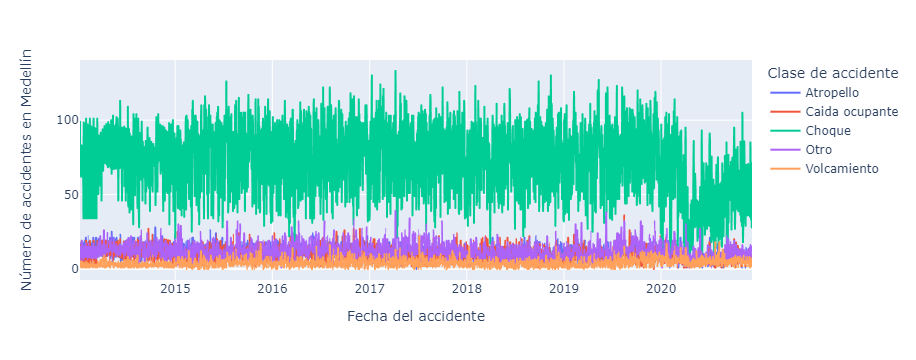

In [113]:
fig = px.line(datos_modelo, x="FECHA_ACCIDENTE", y="Y", color='CLASE_ACCIDENTE',labels={"CLASE_ACCIDENTE":"Clase de accidente",
                                                                                        "Y":"Número de accidentes en Medellín",
                                                                                        "FECHA_ACCIDENTE":"Fecha del accidente"})
fig.show()

<figcaption>Figura 1: Número de accidentes en Medellín por día y clase de accidente (2014 a 2020) </figcaption>

In [70]:
filtro_incendio=datos_modelo["CLASE_ACCIDENTE"]!="Incendio"
datos_modelo=datos_modelo[filtro_incendio].reset_index().drop(labels="index", axis=1)
fecha_accidente=datos_modelo[datos_modelo["Y"]>0].groupby(by="YEAR").aggregate({"FECHA_ACCIDENTE":["nunique"],
                                                                          "FESTIVO":["sum"],
                                                                         "QUINCENA":["sum"]})
fecha_accidente.columns=["Días por año","Festivos","Quincenas" ]
fecha_accidente[["Festivos","Quincenas"]]=(fecha_accidente[["Festivos","Quincenas"]]/5).round()
fecha_accidente

Días por año  Festivos  Quincenas
YEAR                                   
2014           181       7.0       23.0
2015           365      18.0       59.0
2016           366      18.0       59.0
2017           365      18.0       60.0
2018           365      18.0       59.0
2019           365      17.0       59.0
2020           244      13.0       44.0


En la Figura 1 se observa la cantidad de accidentes por dia desde del año 2014 hasta el 2020, esto para cada tipo de accidente (gráfico iteractivo). Se observa:

* Como se menciono en los pasos a seguir para construir la variable $Y_{(t,a)}$ en el año 2014 y 2020 se observa que en varios intervalos de tiempo ocurrieron 0 accidentes, esto quiere decir que no hubo registro de accidentes, sin embargo, en 2014 desde enero hasta julio solo se tiene registro de los días 8, 9, 10, 11 y 12 (5 días por mes) y a partir de julio hasta dicimbre no se encuentra registro de los días 1, 2, 3, 4, 5 y 6. Para 2020 sucede algo similar desde Enero hasta agosto no se cuenta registro de accidentes entre los días 9, 10, 11 y 12 también a partir de septiembre solo se tiene registro de los días 1 al 8 de cada mes; todo lo anterior ocurre para todos los tipos de accidente. También el la Table 3 se observa que en total días por año existen registros en todos los días del año excepto 2014 y 2020 (incluso 2016 esta el año bisiesto).

* En este gráfico también se incluyen los incendios, se selecciona este tipo de accidente en 1 día ha ocurrido a lo mas 1 accidente en la granja de tiempo pero no se observa algún tipo de estacionalidad de ocurrencia o tendencia con respecto al tiempo.

* Los tipo de accidente choque presentan mayor accidentalidad que los demás accidentes, los accidentes por caida de ocupante, atropello y otro parece tener un mismo comportamiento promedio en accidentes y variabilidad. Volcamiento es el que presenta menos accidentalidad (excluyendo incendios).

* Por cada tipo de accidente parece existir una componente estacional que no necesariamente es constante.

Según esto para los registros en 0 del  2014 y 2020 se deben considerar como NA entonces se pronone una interpolación para estos datos.

#### Interpolación de datos

Existen muchos metodos de interpolación de datos pero se debe encontrar el mas apropiado para este caso, como se observa en la Figura 1 se tienen 5 series de tiempo (excluyendo incendio) y donde existe una clara componente estacional.

- Se seleccionan las fechas donde se encontro el patrón.

- El número de accidentes lo pasamos de 0 a NA.

- Se gráfica las posibles componentes estacionales para realizar interpolación.

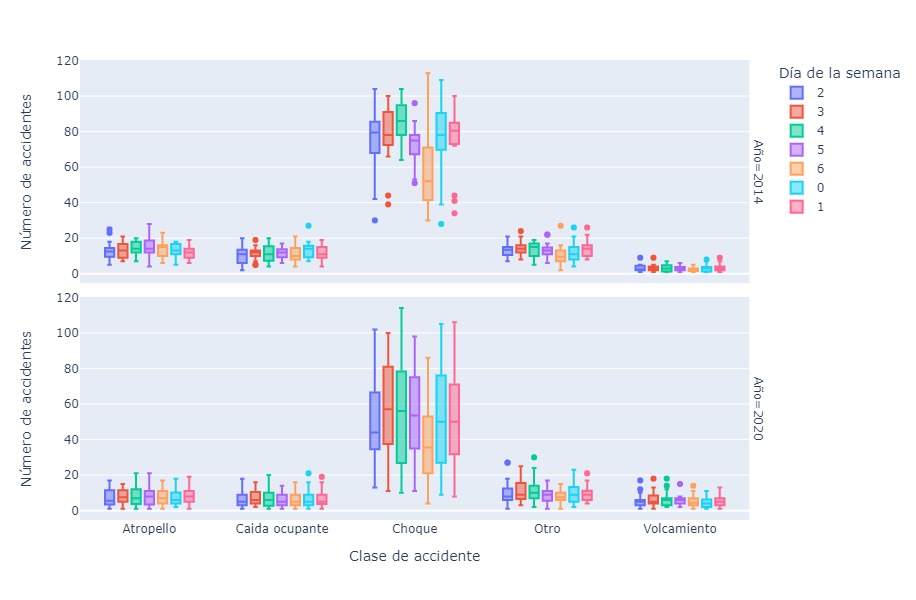

In [71]:
fechas_na=(datos_modelo[datos_modelo["Y"]==0].groupby(by="FECHA_ACCIDENTE")["CLASE_ACCIDENTE"].count()==5).index
filtro_fechas_na=datos_modelo['FECHA_ACCIDENTE'].isin(fechas_na)

filtro_2014=datos_modelo['FECHA_ACCIDENTE']<pd.to_datetime("2015-01-01 00:00:00" ) 
filtro_2020=datos_modelo['FECHA_ACCIDENTE']>=pd.to_datetime("2020-01-01 00:00:00" )
filtro_grafico=(filtro_2014 | filtro_2020) & (~filtro_fechas_na)
datos_modelo.loc[(filtro_2014 | filtro_2020) & (filtro_fechas_na), "Y"]=np.nan
fig = px.box(datos_modelo[filtro_grafico ],
             x="CLASE_ACCIDENTE", y="Y", color="DIA_SEMANA",
            facet_row="YEAR",width=900, height=600,labels={"DIA_SEMANA":"Día de la semana",
                                                             "CLASE_ACCIDENTE":"Clase de accidente",
                                                            "Y":"Número de accidentes",
                                                            "YEAR":"Año"})
fig.update_traces(quartilemethod="linear") # or "inclusive", or "linear" by default
fig.show()

<figcaption> Figura 3: Box plots de cantidad de accidente en día de la semana dado el año (2014 y 2020) y la clase de accidente.</figcaption>

En la Figura 3 se observa que puede existir una componente estacional para algunos casos por día de la semana en el año 2014 y 2020, pero es mas notorio en el 2014.

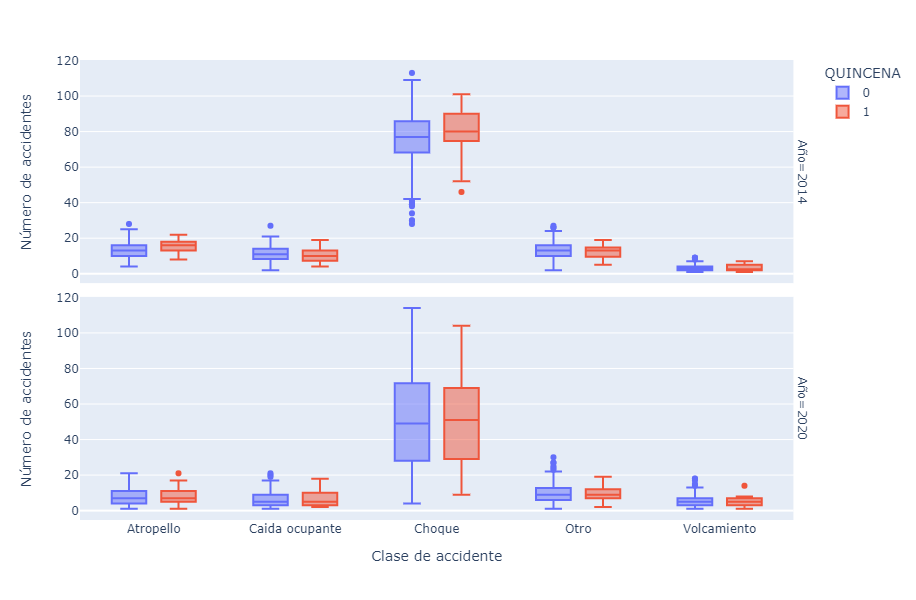

In [73]:
fig = px.box(datos_modelo[filtro_grafico],
             x="CLASE_ACCIDENTE", y="Y", color="QUINCENA",
            facet_row="YEAR",width=900, height=600,labels={"DIA_SEMANA":"Día de la semana",
                                                             "CLASE_ACCIDENTE":"Clase de accidente",
                                                            "Y":"Número de accidentes",
                                                            "YEAR":"Año"})
fig.update_traces(quartilemethod="linear") # or "inclusive", or "linear" by default
fig.show()

<figcaption> Figura 4: Box plots de cantidad de accidente según si es quincena dado el año (2014 y 2020) y la clase de accidente.</figcaption>

En la Figura 4 se observa que los días de quincena tienden a ocurrir mas cantidad de accidentes por cada clase de accidente en ambos años.

No se considero los días festivos por la cantidad de faltantes, el modelo escogido para realizar la interpolación es el metodo lineal ¿por qué? porque los días faltantes estan delimitados por intervalos de tiempo de hasta 15 días donde no hay información y puede ser dificil capturar una tendencia en esos años. La metodología que se uso fue:

Por cada clase se aplica se escogen las combinaciones de dia semana y quincena por cada posibilidad se hace una interpolación lineal para el 2014 y 2020. Se consigue el siguiente resultado. 

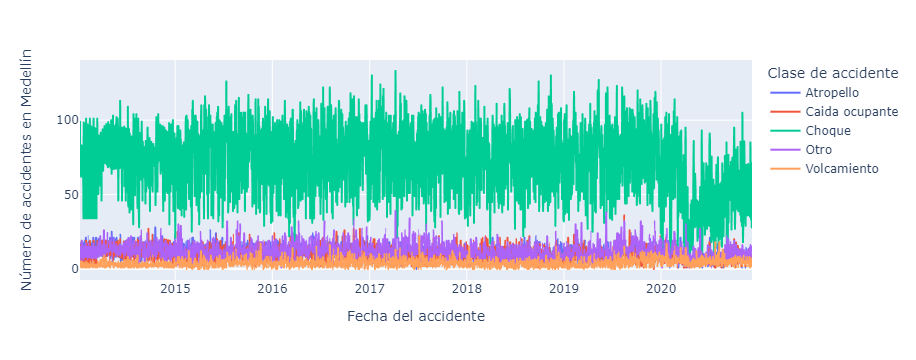

In [112]:
datos_modelo.loc[(filtro_2014 | filtro_2020) & (filtro_fechas_na), "Y"]=np.nan
metodo_="linear"
clases=list(datos_modelo["CLASE_ACCIDENTE"].unique())
for clase in clases:      
    filtro_clase=datos_modelo["CLASE_ACCIDENTE"]==clase
    for dia_semana in datos_modelo["DIA_SEMANA"].unique():
        filtro_semana=datos_modelo["DIA_SEMANA"]==dia_semana
        for quincena_ in range(2):
            filtro_quincena=datos_modelo["QUINCENA"]==quincena_
            filtro_temp=(filtro_clase &
                         filtro_semana &
                          filtro_quincena
                        )  
            filtro_temp_2014=(filtro_temp & filtro_2014   )
            datos_modelo.loc[filtro_temp_2014,'Y']=datos_modelo.loc[filtro_temp_2014,'Y'].interpolate(method = metodo_,
                                                                                                      order=1,
                                                               limit_direction = 'both')
            filtro_temp_2020=(filtro_temp & filtro_2020  )
            datos_modelo.loc[filtro_temp_2020,'Y']=datos_modelo.loc[filtro_temp_2020,'Y'].interpolate(method = metodo_,
                                                                                                      order=1,
                                                               limit_direction = 'both')                
fig = px.line(datos_modelo, x="FECHA_ACCIDENTE", y="Y", color='CLASE_ACCIDENTE',labels={"CLASE_ACCIDENTE":"Clase de accidente",
                                                                                        "Y":"Número de accidentes en Medellín",
                                                                                        "FECHA_ACCIDENTE":"Fecha del accidente"})
fig.show()

<figcaption> Figura 5: Inputación de número de accidentes $Y_{(t,a)}$. </figcaption>

En la Figura 5 se observa los datos interpolados del 2020 y 2014, aunque no se siga la tendencia en el 2014 si parece capturar la media en el tiempo, sin embargo el 2014 no es necesariamente el año importante. Para pronosticar el año 2021 y 2022 es importante capturar la tendencia del 2020, y en el 2020 parece que la imputación de los datos ser buena.

#### Analisis estacional

Luego que tanto puede influir las posibles componentes estacionales en el número de accidentes en Medellín?

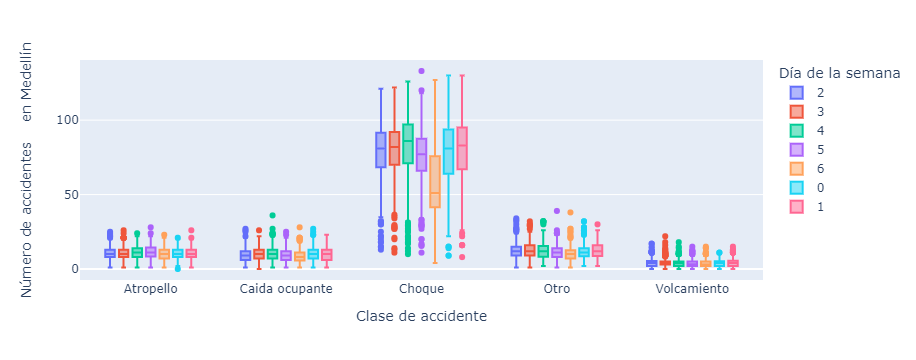

In [121]:
fig = px.box(datos_modelo,
             x="CLASE_ACCIDENTE", y="Y", color="DIA_SEMANA",labels={"DIA_SEMANA":"Día de la semana",
                                                             "CLASE_ACCIDENTE":"Clase de accidente",
                                                            "Y":"Número de accidentes en Medellín",
                                                            "YEAR":"Año"})
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

<figcaption> Figura 7: Box plot Número de accidentes por día de la semana dado la clase de accidente. </figcaption>

En la Figura 7 se observa que para el tipo de accidente por choque puede ser influyente el día de la semana con el número de accidentes. 

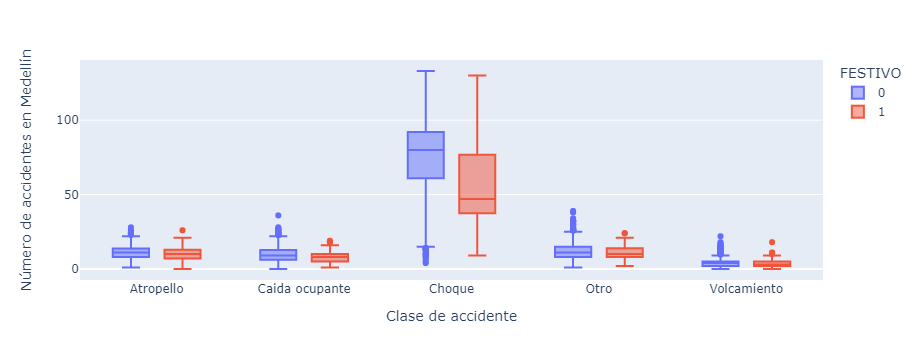

In [122]:
fig = px.box(datos_modelo,
             x="CLASE_ACCIDENTE", y="Y", color="FESTIVO",labels={"DIA_SEMANA":"Día de la semana",
                                                             "CLASE_ACCIDENTE":"Clase de accidente",
                                                            "Y":"Número de accidentes en Medellín",
                                                            "YEAR":"Año"})
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

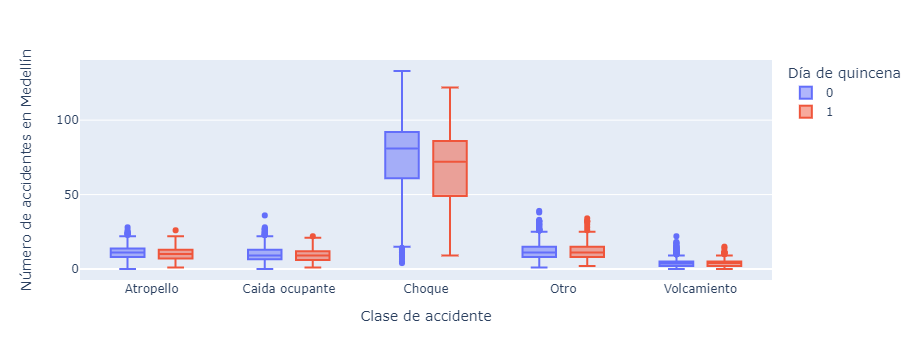

In [123]:
fig = px.box(datos_modelo,
             x="CLASE_ACCIDENTE", y="Y", color="QUINCENA",labels={"QUINCENA":"Día de quincena",
                                                             "CLASE_ACCIDENTE":"Clase de accidente",
                                                            "Y":"Número de accidentes en Medellín",
                                                            "YEAR":"Año"})
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

<figcaption> Figura 8: </figcaption>

<figcaption> Figura 8: Box plot Número de accidentes por si es festivo o no dado la clase de accidente. </figcaption>

En la Figura 8 se observa que para el tipo de accidente por choque puede ser influyente si hay festivo o no, para los otros tipos no parece significativo pero en general existe una tendencia a ocurrir menos accidentes en los días festivos.


<figcaption> Figura 2: Box plot de $Y_t$ discriminado por clase de accidente y Año. </figcaption>

En la Figura 2 se observa que el día de la semana se puede considerar para algunos tipos como accidentes por choque como estacionales, se puede pensar en un modelo que contenga estacionalidad por día de la semana, también se observa que para el año 2020 parece existir una matyor variabilidad donde existen menos ocurrencia de accidentes esto por supuesto debido a la pandemia que inicio en Colombia en el mes de abril. 

Por lo observado en la Figura 1 y 2 para este trabajo se usaran modelos adaptativos lineales se sugiere replicar un modelo AR con regresión lineal como se muestra en la siguiente ecuación.

\begin{equation}
Y_t=\beta_0 +\sum_{i=1}^k \gamma_i Y_{t-i}+ \sum_{j=0}^6 \alpha_j \text{diasemana}_j+ \sum_{l \in \text{clases accidentes}}\theta_l\text{claseaccidente}_l  
\end{equation}

Este es nuestro modelo inicial de referencia.

Para ajustar los modelos no se tendra en cuenta el año 2014 y en el año 2020 solo se considera hasta  el 9 de septiembre por lo observado en al Figura 1.

In [ ]:
datos_modelo_atras=historia_atras(datos_modelo, "Y","CLASE_ACCIDENTE",14 )
datos_modelo_atras=datos_modelo_atras.sort_values(["CLASE_ACCIDENTE","DIAS_REF"])
datos_modelo_atras=datos_modelo_atras.reset_index().drop(labels="index",axis=1)
datos_modelo_atras.head(5)

# pruebas

In [ ]:
datos_prueba=datos_modelo_atras[datos_modelo_atras["CLASE_ACCIDENTE"]=="Atropello"].copy()

In [ ]:
datos_2021=datos_prueba.iloc[-1:]

def nex_day(dia):
    
    return str((int(dia)+1)%7)



def prediccion_dia(fila:pd.DataFrame,modelo_):
    y_t1=modelo.predict(fila)
    return y_t1
def fila_new(fila_anterior:pd.DataFrame):
    lista_y=["Y",'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11',
       'Y12', 'Y13']
    list_y_new=['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11',
       'Y12', 'Y13', 'Y14']
    dia_semana_=nex_day(fila_anterior["DIA_SEMANA"].iloc[0])
    fila_new_=fila_anterior.copy()
    fila_new_[list_y_new]=fila_anterior[lista_y]
    fila_new_["DIA_SEMANA"]=dia_semana_
    
    return fila_new_.copy()

def pronostico_clase_modelo(df_:pd.DataFrame,dias:int,formula_,clase:str):
    modelo_=modelo_lm(df_,formula_)
    filtro=df_["CLASE_ACCIDENTE"]==clase
    datos_pronostico=df_[filtro].iloc[-1:].copy()
    for _ in tq.tqdm(range(dias)):
        fila_temp=fila_new(datos_pronostico.iloc[-1:].copy())
        fila_temp["Y"]=prediccion_dia(fila_temp,modelo_)
        datos_pronostico=pd.concat([datos_pronostico,fila_temp],axis=0)
        
    return datos_pronostico

        
        


In [ ]:
# modelo=resultados.loc[resultados["Formula modelo"]=="Y~Y1+Y2+DIA_SEMANA+Y14","Modelo"].iloc[0]
datos_pronostico=datos_modelo_atras_numerico.drop(labels=["DIAS_REF","FECHA_ACCIDENTE","MES","YEAR"],axis=1).copy()
resultados_prueba=pronostico_clase_modelo(datos_pronostico,800,"Y~Y1+Y2+Y5+DIA_SEMANA+Y14","Choque")

In [ ]:
resultados_prueba

In [ ]:
resultados_prueba=resultados_prueba.reset_index().drop(labels="index",axis=1).reset_index()#["seq"]=resultados_prueba.index
fig = px.line(resultados_prueba, x="index", y="Y",width=900, height=1500)
fig.show()

# fin prueba

En la Table 5 se tiene que las columnas Yi representan a $Y_{t-i}$.

# Modelos predictivos

En esta sección como ya se tiene una estructura de datos para la creación de un modelo se debe tener en cuenta:

* Como se realizara predicción a futuro siempre habrá una extrapolación.

* Se partiran los datos en 2 periodos de tiempo, datos de entrenamiento 2015 al 2018, datos de prueba 2019 al 2020.



In [ ]:
datos_modelo_atras["DIA_SEMANA"]=datos_modelo_atras["DIA_SEMANA"].astype(str)
datos_modelo_atras_numerico=datos_modelo_atras.copy()#.reset_index().drop(labels="index",axis=1).copy()
filtro_validacion=datos_modelo_atras_numerico["YEAR"]<=2018
datos_train=datos_modelo_atras_numerico[filtro_validacion].copy()
datos_test=datos_modelo_atras_numerico[~filtro_validacion].copy()

In [ ]:
formulas_=powerset(7)
resultados=validacion_mult_modelos(datos_train,datos_test, formulas_)

In [ ]:
datos_train

In [ ]:
resultados[resultados["Variación validación (MAE)"]<=15].sort_values("Variación validación (MAE)").tail(50)

In [ ]:
resultados.loc[resultados["Formula modelo"]=="Y~Y1","y_pred"].iloc[0]

In [ ]:
datos_predict=datos_modelo_atras_numerico.copy()
datos_predict["Y_predict"]=resultados.loc[resultados["Formula modelo"]=="Y~Y2+Y3+Y4+Y5+Y6+DIA_SEMANA","y_pred"].iloc[0]
fig = px.line(datos_predict, x="FECHA_ACCIDENTE", y=["Y","Y_predict"], facet_row="CLASE_ACCIDENTE",width=900, height=1500)
fig.show()

In [ ]:
fig=px.line(datos_predict, x="FECHA_ACCIDENTE", y="residuales", color='CLASE_ACCIDENTE')
fig.show()

### Preparación de  datos modelo de agrupamiento

Para agrupar los barrios de medellín  se usara un json que contiene el mapa de medellín discriminado por los barrios.



In [ ]:
vias_medellin=geopandas.read_file("planeacion_gdb/planeacion_gdb.shp")
vias_medellin=vias_medellin.to_crs("EPSG:4326")

In [ ]:
vias_medellin.plot()



In [ ]:
vias_medellin.crs

In [ ]:
# lectura barrios shape
shapefile = geopandas.read_file("Barrio_Vereda.shp")
# str to list
datos["LOCATION"]=datos["LOCATION"].apply(lambda x: ast.literal_eval(x))
# dataframe to geopandas
# sistema de referencia datos : ITRF94
gdf = geopandas.GeoDataFrame(
    datos, geometry=geopandas.points_from_xy(datos.LOCATION.apply(lambda x: x[0]),
                                             datos.LOCATION.apply(lambda x: x[1]),
                                            crs="ITRF94"))
# cambiar sistema de refencia 
# sistema de refencia de barrios es: EPSG:4326
gdf=gdf.to_crs("EPSG:4326")
# join barrios medellin y datos
datos_join=geopandas.sjoin(gdf,shapefile , how='left') 
datos_join=geopandas.sjoin(shapefile,gdf , how='left') 

In [ ]:
datos_join

In [ ]:
fig = px.choropleth_mapbox(df, geojson=counties, locations='fips', color='unemp',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'unemp':'unemployment rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
vias_medellin.plot()
datos_join.plot()

# Referencias

https://www.bluradio.com/blu360/antioquia/que-significa-que-medellin-sea-la-tercera-ciudad-mas-densamente-poblada-del-mundo

https://www.concejodemedellin.gov.co/es/node/1024?language_content_entity=es

https://www.medellin.gov.co/giscatalogacion/srv/spa/catalog.search#/metadata/4f8b2fa9-8f9a-425f-a205-07b52e7d6aae

https://geomedellin-m-medellin.opendata.arcgis.com/datasets/vias-urbano-rural/explore?location=6.378506%2C-75.493262%2C10.09